# 0. Import libs

In [2]:
import pandas as pd
import numpy as np
import re
import math
import collections as co
import  scipy
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import pysubgroup as ps
from yellowbrick.features import Rank2D,RFECV


In [3]:
# Только для красоты, в реальной жизни Warnings могут помочь найти ошибку в коде
import warnings
warnings.filterwarnings('ignore')

In [4]:
def write_answer(file_name,answer):
    file = open('./results/'+str(file_name) + '.txt','w') 
    file.write(str(answer) ) 
    file.close() 
write_answer('self0','example_answer')
#к каждой задаче задаче записывайте ответ в виде self{X} , где {X} это номер задачи в заголовке

# 1. load data

In [107]:
client_sms = pd.read_csv('./data/clientSMS_v2.csv', sep='\t', names = ['text', 'sentiment'])

negative_tweet = pd.read_csv('./data/negative.csv', sep=';', usecols=[3], names=['text'])
negative_tweet['sentiment'] = 2

positive_tweet = pd.read_csv('./data/positive.csv', sep=';', usecols=[3], names=['text'])
positive_tweet['sentiment'] = 1

kaggle_sentiment = pd.read_json('./data/kaggle_sentiment.json', encoding='UTF-8')
kaggle_sentiment = kaggle_sentiment[['text','sentiment']]

In [121]:
df = pd.concat([kaggle_sentiment, client_sms, negative_tweet, positive_tweet], axis=0, ignore_index=True)

# 2. preproc

In [122]:
df['text'] = df['text'].str.replace("\n"," ")

df['sentiment'] = df['sentiment'].astype(str).replace("negative",2)
df['sentiment'] = df['sentiment'].astype(str).replace("positive",1)
df['sentiment'] = df['sentiment'].astype(str).replace("neutral",0)

df['sentiment'] = df['sentiment'].astype(int)

In [110]:
df['text']

0         Досудебное расследование по факту покупки ЕНПФ...
1         Медики рассказали о состоянии пострадавшего му...
2         Прошел почти год, как железнодорожным оператор...
3         По итогам 12 месяцев 2016 года на территории р...
4         Астана. 21 ноября. Kazakhstan Today - Агентств...
                                ...                        
238992    Спала в родительском доме, на своей кровати......
238993    RT @jebesilofyt: Эх... Мы немного решили сокра...
238994    Что происходит со мной, когда в эфире #proacti...
238995    "Любимая,я подарю тебе эту звезду..." Имя како...
238996    @Ma_che_rie посмотри #непытайтесьпокинутьомск ...
Name: text, Length: 238997, dtype: object

In [123]:
#self1
#удалите все ники с учетом первого символа @
#превратите двойные пробелы в одинарные
#запишите ответ первого задания как количество всех симфолов в тексте в поле "text" после преобразований
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.replace.html
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.len.html
import re

#Ник всегда начинается с @, а заканчиваться может : или пробелом (иначе он неотделим от текста), 
df=df.replace('@(.*?) ', ' ', regex=True) 
df=df.replace('  ', ' ', regex=True)
coun = np.sum(df.text.str.len())
print(coun)
write_answer('self1', coun)

48900540


In [112]:
# Проверим, удалились значения. Ник - это пространство символов между собакой и пробелом
# Данная информация извлечена в рамках интервью в чата телеграм
print(df.loc[238993][0])
print(df.loc[238996][0])

RT Эх... Мы немного решили сократить путь, сейчас уже лежу в мягкой кровати :) а с отсутствием сети помогла справится какая-
 посмотри #непытайтесьпокинутьомск сегодня в Вавилоне в 18.20. Я там тоже есть :)


In [30]:
#Вернемся в прошлое и получим значения тех же строк до замен
print(df.loc[238993][0])
print(df.loc[238996][0])

RT @jebesilofyt: Эх... Мы немного решили сократить путь, сейчас уже лежу в мягкой кровати :) а с отсутствием сети помогла справится какая-
@Ma_che_rie посмотри #непытайтесьпокинутьомск сегодня в Вавилоне в 18.20. Я там тоже есть :)


In [124]:
#self2
#превратите все числа в фразу "число"
#запишите ответ второго задания как количество всех симфолов в тексте в поле "text" после преобразования

#Возьмем упрощения - число может быть только целым (если между цифрами есть знаки, то они принадлежат разным числам). 
#Даты разбираем как вещественные числа, которые идут друг за другом
df['text'] = df['text'].replace('[0-9]*[0-9]', 'число', regex=True)
coun = np.sum(df.text.str.len())
print(coun)
write_answer('self2', coun)

49821239


In [114]:
#Проверяем результат - все числа заменились на фразу число
df

,text,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,2
1,Медики рассказали о состоянии пострадавшего му...,2
2,"Прошел почти год, как железнодорожным оператор...",2
3,По итогам число месяцев число года на территор...,2
4,Астана. число ноября. Kazakhstan Today - Агент...,2
5,Об аресте бывшего министра национальной эконом...,2
6,Двое налетчиков совершили нападение на охранни...,2
7,"""Самрук-Энерго"" в I квартале почти вдвое снизи...",2
8,В число году почти половина коррупционных прес...,2
9,Google+ Чт число янв число число:число:число О...,2


In [115]:
df['text']= df['text'].str.lower()

In [128]:
print(df['text'].str.count('не_').sum())

94518


In [127]:
print(df['text'][0])

Досудебное расследование по факту покупки ЕНПФ пакета облигаций ТОО "Бузгул Аурум" было начато по инициативе Национального банка РК, сообщил директор департамента защиты прав потребителей и финансовых услуг Нацбанка Казахстана Александр Терентьев. "Основанием для досудебного расследования стало обращение Национального банка, письмо от число ноября число года. Было обращение Национального банка в правоохранительные органы. Нам эта сделка показалась сомнительной, недостаточно корректной, поэтому Нацбанк число ноября число года обратился в правоохранительные органы. Это то, что я могу озвучить на сегодня. Идёт следствие, проводится проверка", – сказал Терентьев. число декабря в Нацбанке заявили, что не_знают, что стало основанием для проверки ЕНПФ. число декабря факт проведения проверки в АО "Единый накопительный пенсионный фонд" подтвердился. Пресс-служба Национального банка сообщила, что проверку проводят по операциям, совершённым АО "ЕНПФ" в отношении инвестирования собственных активов

In [129]:
#self3
#предлог "не" имеет противоположный эффект к слову, мы не можем не учитывать это, давайте соединим не и слово с помощью замены "не " на "не_"
#важно - учтите, что есть слова, которые заканчиваются на "не", не ошибитесь
#ответом на третье задание будет количество "не_" в текстах колонки text

#Учтем ситуации, когда не в начале строки и когда не в середине текста (случаи когда в конце строк не с пробелом не учитываем)
#так как это решается функцией трим, в данном случае не применяю, чтобы подсчет символов не сбить
df['text'] = df['text'].replace(' не ', ' не_', regex=True) 
# можно переделать в 1 regex, это первый вариант, который пришел в голову
df['text'] = df['text'].replace('^не ', 'не_', regex=True)
coun = df['text'].str.count('не_').sum()
print(coun)
write_answer('self3',coun)

94518


In [117]:
#перемешаем наш датасет, т.к. он состоит из разных выборок данных
df = df.sample(frac=1 ).reset_index(drop = True)[:]

# 3. factor generator

In [118]:
df['cnt_!'] = df['text'].str.count('\!')
df['cnt_?'] = df['text'].str.count('\?')
df['cnt_.'] = df['text'].str.count('\.')

In [119]:
df

,text,sentiment,cnt_!,cnt_?,cnt_.
0,ухожу в запойную депрессию. ебаных два года уб...,2,0,0,1
1,и холодильник не_работает,2,0,0,0
2,"кто говорит, что php ужасен, никогда не_видел ...",2,0,0,0
3,не_смогу поехать сегодня(,2,0,0,0
4,у меня родственник всё что можно тырит!)) даж...,1,3,0,2
5,rt он признался ей в любви на #євромайдан. цве...,1,0,0,6
6,можно я изолью тебе душу?(((,2,0,1,0
7,и не_только у него(((( я сама уже боюсь. меня...,2,0,0,1
8,"мне наверное нельзя такие передачи смотреть, а...",2,0,0,0
9,загадала я это желание тупое. все равно не_сбу...,2,0,0,1


In [20]:
#self4 
#добавим фактор количество слов в предложении
#давайте посчитаем среднее целое округленное до ближайшего значения вверх количество слов в сообщениях как ответ к четвертому заданию

#Словом посчитаем любую последовательность букв на русском или английском
coun = 0
average_count = 0
count_sum = 0
i = 0
df['cnt_words'] = np.nan
for stroka in df['text']:
    coun = len(re.findall("[a-zA-Z_]+|[а-яА-Я]+", stroka))
    df['cnt_words'][i] = int(coun)
    count_sum += coun
    i += 1
    
avg_count = count_sum / len(df)
write_answer('self4', math.trunc(avg_count) + 1)

In [21]:
df

,text,sentiment,cnt_!,cnt_?,cnt_.,cnt_words
0,ленаааааа я хочууууууу число.число.число - чис...,1,0,0,5,19.0
1,"блин, забыл католиков с рождеством поздравить((",2,0,0,0,6.0
2,кошка в это время рвала мои джинсы и не_давал...,1,0,0,0,20.0
3,приехала домой на концерте тухло было... долго...,2,0,0,3,11.0
4,"rt спасибо с: типе тоже, если ты конечно буде...",1,0,0,1,23.0
5,о_даа...как вспомню..валерка вообще лошок=)),1,0,0,5,8.0
6,программа утилизации вышедших из употребления ...,0,0,0,11,214.0
7,"rt ахахахаххх боже, не_смеши меня опять:d я у...",1,0,0,0,24.0
8,"ой, да всё у тебя получится) главное, настрои...",1,0,0,0,13.0
9,"мне не_лучше, мне хуже((( бееее всю ночь не_спала",2,0,0,0,12.0


In [24]:
df.describe()

,sentiment,cnt_!,cnt_?,cnt_.,cnt_words
count,238997.000000,238997.000000,238997.000000,238997.000000,238997.000000
mean,1.451039,0.292263,0.176333,2.084850,30.454198
std,0.547576,1.103616,0.722339,15.983359,240.671307
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,9.000000
50%,1.000000,0.000000,0.000000,0.000000,12.000000
75%,2.000000,0.000000,0.000000,1.000000,17.000000
max,2.000000,121.000000,44.000000,2901.000000,48210.000000


In [62]:
round(avg_count / 7)

4

(6.995290286494739, 17.00470971350526)


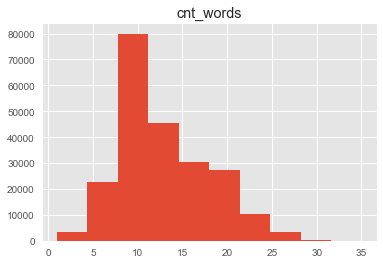

In [82]:
#self5
#давайте визуализируем гистаграмму количества слов в тексте https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
t =pd.DataFrame({'cnt_words': sorted(df['cnt_words'])})
t.hist()
ax.set_title('Headline Word Lengths')
ax.set_xticks(range(1,60))
ax.set_xlabel('Number of Words')
#
#нарисуем поверх нее плотность нормального распределения с матожиданием в медиане и дисперсией 1/7 от среднего количества слов в предложении
x = np.linspace(min(word_counts), max(word_counts), 100)
l = ax.plot(x, mlab.normpdf(x, df['cnt_words'].median(), avg_count / 7 ), '-')

#давайте посчитаем 75% доверительный интервал для количества сообщений по заданнорму нормальному распределенению
conf_interval = stats.norm.interval(0.75, loc=df['cnt_words'].median(), scale=avg_count / 7)
print(conf_interval)

#ответом на пятое задание есть массив левая и правая граница доверительного интервала округленная до 2 знака после запятой, записанная через запятую.
write_answer('self5',[round(conf_interval[0], 2) , round(conf_interval[1], 2)])


In [120]:
print(round(conf_interval[0], 2))

7.0


In [50]:
#self6
#оставим в нашем датасете только те сообщения, которые охватываются нашим доверительным интервалом
#, чтобы модель не переобучалась на слишком длинных сообщениях

#до удаления
print(df.shape[0])
df = df.drop(df[(df.cnt_words < conf_interval[0]) | (df.cnt_words > conf_interval[1])].index)
#ответом на 6 задание будет новое значение количества строк в нашем датафрейме
#после удаления
print(df.shape[0])
write_answer('self6', df.shape[0])

238997
159959


# 4. load hard dataset

In [ ]:
#1 - смайлики
#2 - знаки
#3 - уменьшительно ласкательные суффиксы
#4 - явные слова
#5 - матерные слова
#6 - увеличение и уменьшение
#7 - стандарты автоответов
#8 - жизнь хорошо, смерть плохо
#9 - друг хорошо, враг плохо
#10 - ужас, страх это плохо
#11 - троеточие или две точки чаще плохо, больше 3 точек чаще хорошо
#12 - стандарты магазинов это позитивчик
#13 - когда скучают это хорошо
#14 - приветствие это хорошо
#15 - тянущиеся гласные это хорошо
#16 - эмоции
#17 - срочность это плохо, отрицание срочности хорошо
#18 - количество слов в смс
#19 - предлог "бы" чаще плохо
#20 - предлог "не" чаще плохо
#21 - отсутствие "никто" чаще плохо
#22 - интерес это хорошо
#23 - нужен это хорошо
#24 - действие это хорошо
#25 - отсутствие действия это плохо
#26 - суффикс повелительный это плохо
#27 - быстрое действие это хорошо перед нейтральным словом это плохо
#28 - согласие это хорошо
#29 - наказание это плохо
#30 - благодарность это хорошо
#31 - жаргон это плохо
#32 - отдых это хорошо
#33 - пожелания это хорошо
#34 - мольба это хорошо
#35 - радостные слова
#36 - Уменьшительные имена это хорошо
#37 - скука это хорошо
#38 - волнение это плохо
#39 - предлог некогда плохой
#40 - наименование животным это хорошо
#41 - отказ это плохо
#42 - сочетание знаков !? или ?! это плохо
#43 - обязательства это плохо
#44 - злось это плохо
#45 - добрые пожелания это хорошо
#46 - оскорбления это плохо
#47 - начало предложения с "И" или "АУ" это плохо
#48 - траты это плохо
#49 - обман это плохо
#50 - свобода это хорошо
#51 - упоминание стран курорта это хорошо
#52 - комбинация ахахаха это хорошо
#53 - не это плохо
#53 - ничего перед не убирает отрицание не перепи
#53 - или перед не и нет убирает плохое состояние
#54 - радость это хорошо
#55 - когда что-либо нравится это хорошо

In [5]:
df = pd.read_csv('./data/full_df.csv')

# 5. model

In [6]:
df.head()

,text,sentiment,cnt_!,cnt_?,cnt_.,cnt_words,rule_1,rule_2,rule_3,rule_4,...,rule_47,rule_48,rule_49,rule_50,rule_51,rule_52,rule_53,rule_54,rule_55,final_rule
0,"та уже вроде все получается, но вот не_знаю м...",2,0,0,0,12,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,"если, конечно, тьфу-тьфу!!! уже не_привело:((((",2,3,0,0,7,-4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,"rt ой,так хорошо с заей поболтали,она мне гово...",1,0,0,1,23,3.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
3,пока смотрели фильм считали подъебы про чёрных...,1,0,0,1,15,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,сидим возле стеллы. хорошо :) только берег под...,1,0,0,4,8,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [7]:
#self7
#subgroup discovery
#исследуем наши данные
#давайте выделим таргет позитивных сообщений и посмотрим что на них влияет
#выводим для датафрейма df_subd, т.к. иначе будет долго считать
df_subd = df.sample(3000)

#выделете таргет sentiment положительный
target = ps.NominalTarget(target_selector=ps.NominalSelector('sentiment', True))

#задайте область поиска весь датафрейм игнорируя поле sentiment
searchSpace = ps.create_selectors(df_subd, ignore=['sentiment']) 

#задайте задачу поиска SubgroupDiscoveryTask влияния на таргет target в поле поиска searchSpace
#найдите 3 подгруп
#по глубине 2 предикатами
#функцию качества задайте на базе Chi2 ps.StandardQF(1)
task = ps.SubgroupDiscoveryTask(
    df_subd,
    target=target,
    search_space=searchSpace,
    result_set_size = 3, # на выход получаем 3 подгрупп
    depth = 2, # Каждая подгруппа описывается не более чем 2 предикатами
    qf = ps.StandardQF(1)
                )


result = ps.BeamSearch().execute(task)

#выведете результаты
for (q,sg) in result:
    print(str(q) + ":\t" + str(sg.subgroup_description))
    
#сохраните значение q и описание подгруппы первой самой большой как ответ к заданию 7 в формате массива [0.123 , "dada"]
#print(str(result[0][0]) | str(result[0][1]))
write_answer('self7', [result[0][0] , result[0][1]])


0.015995555555555555:	cnt_.: [1:2[ AND rule_26=0.0
0.015989333333333338:	cnt_.: [1:2[ AND rule_30=0.0
0.015659111111111113:	cnt_.: [1:2[ AND rule_42=0.0


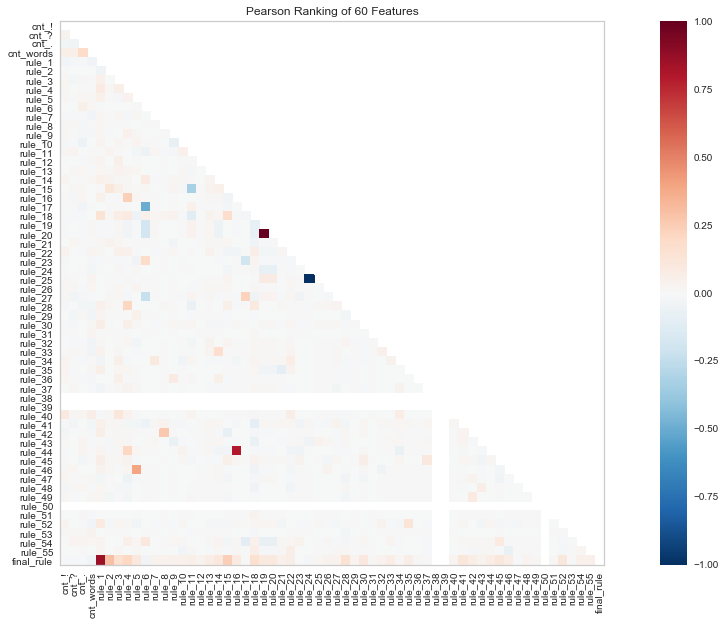

In [8]:
# постройте матрицу корреляций факторов Rank2D через библиотеку yellowbrick
#постройте то количество, которое будет удобно выводиться у вас на компьютере
names = np.delete(df.columns.values, [0,1])#оставьте массив имен без поля 'text' и 'sentiment'
_, ax = plt.subplots(figsize=(20,10))
rank = Rank2D(ax=ax, features=names, algorithm='pearson')
rank.fit(df_subd[names]#укажите наш датафрейм df_subd по колонкам выделенных факторов names
        ,target#укажите наш датафрейм df_subd по таргет переменной
        )
#Здесь была неправильная подсказка?
rank.transform(df_subd[names]   #укажите наш датафрейм df_subd по колонке таргета
                )
rank.poof()

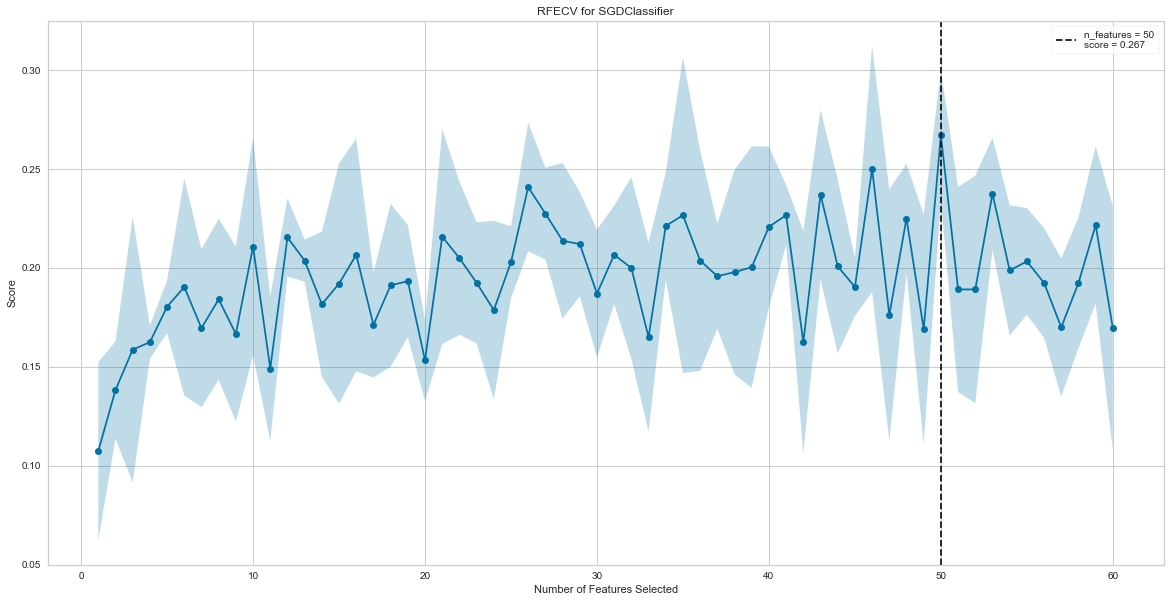

In [9]:
#сделаем простую модель и постараемся выбрать лучшие факторы для нее через RFECV
from sklearn import   linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.model_selection import ShuffleSplit, train_test_split , StratifiedShuffleSplit

classifier = SGD()

cv=ShuffleSplit(n_splits=4, train_size=0.8, test_size=0.2, random_state= 42)

_, ax = plt.subplots(figsize=(20,10))
rfe = RFECV(classifier, cv=cv, step=10)
rfe.fit(df_subd[names], df_subd['final_rule'])
rfe.poof()

In [10]:
#self8
#создадим параметры  рангов полей на нашем датасете df_subd[names]
params = {
    'parameters': list(df_subd[names].columns),
    'ranking':rfe.ranking_
}

#сделайтее список из факторов третьего ранга
par = pd.DataFrame(data=params)
best_params = list(par[par['ranking']==3]['parameters'])

#ответом на 8 задание будет массив факторов третьего ранга
write_answer('self8', best_params)

In [11]:
#в моем случае параметров 3 ранга не оказалось, поэтому передаваемый массив пустой
params

{'parameters': ['cnt_!',
  'cnt_?',
  'cnt_.',
  'cnt_words',
  'rule_1',
  'rule_2',
  'rule_3',
  'rule_4',
  'rule_5',
  'rule_6',
  'rule_7',
  'rule_8',
  'rule_9',
  'rule_10',
  'rule_11',
  'rule_12',
  'rule_13',
  'rule_14',
  'rule_15',
  'rule_16',
  'rule_17',
  'rule_18',
  'rule_19',
  'rule_20',
  'rule_21',
  'rule_22',
  'rule_23',
  'rule_24',
  'rule_25',
  'rule_26',
  'rule_27',
  'rule_28',
  'rule_29',
  'rule_30',
  'rule_31',
  'rule_32',
  'rule_33',
  'rule_34',
  'rule_35',
  'rule_36',
  'rule_37',
  'rule_38',
  'rule_39',
  'rule_40',
  'rule_41',
  'rule_42',
  'rule_43',
  'rule_44',
  'rule_45',
  'rule_46',
  'rule_47',
  'rule_48',
  'rule_49',
  'rule_50',
  'rule_51',
  'rule_52',
  'rule_53',
  'rule_54',
  'rule_55',
  'final_rule'],
 'ranking': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1])